@Summary
    This code is to generate the .csv Ngoc want with census tract, min station travel time, average travel time.
    1) use the 200x200 grid (3200x3200 grid has 0 min travel times, I don't know why, but its intentional)  
    3) find the regions that stations are in
    4) calculate the distance between each region
    5) use existing code?
@Author 
    Joshua Ong


In [1]:
import csv
import collections
import pandas as pd
import numpy as np
import math
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#MAPS fips to region
with open("geoid_for_grid3200.json","r") as json_file:
     census_json = json.load(json_file)

In [3]:
census_json 

{'48453000402': [1195],
 '48453001912': [1247,
  1307,
  1308,
  1368,
  1369,
  1370,
  1373,
  1429,
  1431,
  1433,
  1493,
  1494],
 '48491020804': [2361,
  2422,
  2423,
  2424,
  2483,
  2484,
  2485,
  2544,
  2545,
  2546,
  2547],
 '48491021507': [2600, 2601, 2661, 2662, 2663, 2723, 2724, 2786],
 '48491020603': [2595, 2596, 2597, 2598, 2599, 2658, 2659, 2660],
 '48491021504': [2722, 2783, 2784, 2785, 2845, 2846],
 '48491020806': [2605, 2606, 2607, 2608, 2666, 2667, 2668, 2669, 2726, 2727],
 '48209010806': [8,
  69,
  70,
  131,
  192,
  193,
  253,
  254,
  255,
  256,
  314,
  315,
  316,
  317,
  318,
  319,
  375,
  376,
  377,
  378,
  379,
  380,
  381,
  436,
  437,
  438,
  439,
  440,
  441,
  497,
  498,
  499,
  500,
  501,
  502,
  558,
  559,
  560,
  561,
  562,
  563,
  619,
  620,
  621,
  622,
  623,
  624],
 '48209010908': [28, 29, 30, 90],
 '48209010809': [680,
  681,
  682,
  683,
  684,
  685,
  686,
  741,
  742,
  743,
  744,
  745,
  746,
  747,
  748,
 

In [4]:
# Straight up grid
class Grid():
    def __init__(self, grid_json):
        self.grid = grid_json
        self.min_lat = self.grid["latitude_min"]
        self.min_lon = self.grid["longitude_min"]
        self.max_lat = self.grid["latitude_max"]
        self.max_lon = self.grid["longitude_max"]
        self.latitude_delta = self.grid["latitude_step"]
        self.longitude_delta = self.grid["longitude_step"]
        self.nrows = math.ceil((self.max_lat - self.min_lat) / self.latitude_delta)
        self.ncols = math.ceil((self.max_lon - self.min_lon) / self.longitude_delta)
        self.times = self.grid["time_matrix"]
        self.census_tract_region_map = self.grid["census_tract_region_mapping"]
        self.region_to_tract = collections.defaultdict(list)
        for census_tract in self.census_tract_region_map:
            for region in self.census_tract_region_map[census_tract]:
                self.region_to_tract[region].append(census_tract)
    def map_point_to_region(self, latitude, longitude):
        return math.floor((latitude-self.min_lat)/self.latitude_delta) * self.ncols  + math.floor((longitude-self.min_lon)/self.longitude_delta)
    def get_representative(self, region_num):
        row_num = region_num//self.ncols
        col_num = region_num - row_num*self.ncols
        lat = self.min_lat + row_num * self.latitude_delta + 0.5*self.latitude_delta
        lon = self.min_lon + col_num * self.longitude_delta + 0.5*self.longitude_delta
        return [lon, lat]
    def get_time(self, region1, region2):
        try:
            return self.times[region1][region2]
        except IndexError:
            return -1
    def region_to_census_tract(self, region):
        try:
            return self.region_to_tract[region]
        except KeyError:
            return "0_0"

In [11]:
# Using smaller distance matrix for hopefully faster runtime of Julia code
with open("../Input_Data/grid_info_multiple.json", "r") as f:
    grid_json = json.load(f)
grid_json["census_tract_region_map"] = census_json
g = Grid(grid_json)
num_regions = 3200

In [6]:
g.census_tract_region_map = census_json
g.census_tract_region_map
grid_json["census_tract_region_map"]

{'48453000402': [1195],
 '48453001912': [1247,
  1307,
  1308,
  1368,
  1369,
  1370,
  1373,
  1429,
  1431,
  1433,
  1493,
  1494],
 '48491020804': [2361,
  2422,
  2423,
  2424,
  2483,
  2484,
  2485,
  2544,
  2545,
  2546,
  2547],
 '48491021507': [2600, 2601, 2661, 2662, 2663, 2723, 2724, 2786],
 '48491020603': [2595, 2596, 2597, 2598, 2599, 2658, 2659, 2660],
 '48491021504': [2722, 2783, 2784, 2785, 2845, 2846],
 '48491020806': [2605, 2606, 2607, 2608, 2666, 2667, 2668, 2669, 2726, 2727],
 '48209010806': [8,
  69,
  70,
  131,
  192,
  193,
  253,
  254,
  255,
  256,
  314,
  315,
  316,
  317,
  318,
  319,
  375,
  376,
  377,
  378,
  379,
  380,
  381,
  436,
  437,
  438,
  439,
  440,
  441,
  497,
  498,
  499,
  500,
  501,
  502,
  558,
  559,
  560,
  561,
  562,
  563,
  619,
  620,
  621,
  622,
  623,
  624],
 '48209010908': [28, 29, 30, 90],
 '48209010809': [680,
  681,
  682,
  683,
  684,
  685,
  686,
  741,
  742,
  743,
  744,
  745,
  746,
  747,
  748,
 

In [10]:
travel_times_for_x = []
x = 100
for i in range(3200):
    travel_time = g.get_time(i,x) / 60
    travel_times_for_x.append(travel_time)
plt.plot(travel_times_for_x)
plt.ylim(0,100)
plt.show()

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

## Okay so we included the grid. Now we are adding the station times.

In [42]:
stations = pd.read_csv("Input_data/stations.csv")
numstations = stations["LATITUDE"].size # Should be 51
numregions = g.nrows * g.ncols

coverage_times = np.ones(shape=(numstations, numregions)) #* 15???
coverage = np.ones(shape=(numstations, numregions)) #* 15

In [44]:
region_numbers = range(1, numregions + 1)

station_numbers = ["".join(["x", str(i)]) for i in range(1, numstations + 1)]

coverage = pd.DataFrame(data=coverage, index=station_numbers, columns=region_numbers)

In [91]:
#maps the stations to the grid cells/ regions then finds the travel time inbetween
for station in range(0, numstations):
    region_of_station = g.map_point_to_region(stations["LATITUDE"][station], stations["LONGITUDE"][station])
    for region in range(0, numregions):
        travel_time = g.get_time(region_of_station, region)
#         if(travel_time == 0):
#             travel_time = 3
        coverage.at["x"+str(station+1), region+1] = travel_time


In [92]:
coverage_np = coverage.to_numpy()
coverage_np = coverage_np[:,0:num_regions]
coverage_np.shape

(44, 3200)

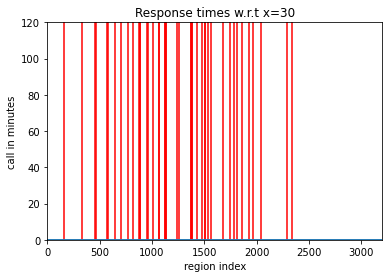

In [93]:
#plot station w.r.t travel times 
#include stations as vertical lines
#x = 35 looks good
list_of_station_regions = []
for station in range(0, numstations):
    region_of_station = g.map_point_to_region(stations["LATITUDE"][station], stations["LONGITUDE"][station])
    list_of_station_regions.append(region_of_station)
    plt.axvline(x = region_of_station, color = 'r', label = 'axvline - full height')

travel_times_for_x = []
x = 30
for i in range(num_regions):
    travel_time = g.get_time(i,x) / 60
    travel_times_for_x.append(travel_time)
plt.plot(travel_times_for_x)
plt.ylim(0,120)
plt.xlim(0,num_regions)
plt.xlabel('region index')
plt.ylabel('call in minutes')
plt.title('Response times w.r.t x=30')
plt.show()

In [96]:
#Assumes coverage.np is global
#returns: closest average of nearest 5
#this function is for regions time, the later one is region2census
def get_min_and_avg(i):
    station_X_2_region = coverage_np[:,i]
    station_X_2_region.sort()
    min = station_X_2_region[0]  
    average = np.sum(station_X_2_region[0:5]) / 5
    if(min == 0) and (average != 0):
        min = 180
        print("case")
    return [min/60,average/60]

In [97]:
#generate region_travel_times
region_travel_times = np.zeros([num_regions,3]) #id, min, avg
for i in range(num_regions):
    temp = get_min_and_avg(i)
    region_travel_times[i,:] = [i,temp[0],temp[1]]
    #print(region_travel_times[i,:])

case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case
case


In [99]:
np.savetxt('per_grid_min_travel_time.csv', region_travel_times, delimiter=',')

(0.0, 20.0)

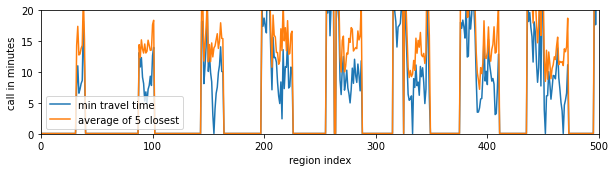

In [78]:
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(5)
ax1 = fig.add_subplot(211)
ax1.plot(region_travel_times[:,1]) #graph sanity check
ax1.plot(region_travel_times[:,2]) #graph sanity check
ax1.set_xlabel('region index')
ax1.set_ylabel('call in minutes')
ax1.legend(["min travel time", "average of 5 closest"])
ax1.set_xlim([0,500])
ax1.set_ylim([0,20])

# for i in grid_json["census_tract_region_mapping"]['Census Tract 9501']:
#     plt.axvline(x = i, color = 'r', label = 'axvline - full height')
#     print(i)


## Now we will go from min station time to min census tract time.

In [100]:
geo_freq = (np.genfromtxt("geo_distribution.csv", delimiter=","))
a = np.concatenate( geo_freq, axis=0 )
geo_freq = np.vstack( geo_freq )
geo_freq.shape

(53, 61)

In [101]:
census_json['Census Tract 9800']
coverage_np[:,648]

KeyError: 'Census Tract 9800'

In [102]:
region_travel_times[587,1]

6.235

In [103]:
geo_freq.shape

(53, 61)

1252
2421
1218


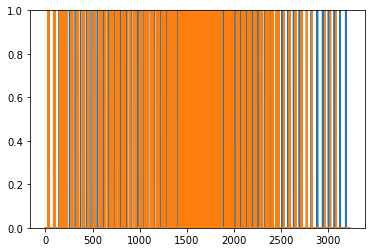

In [104]:
#check if zero minute travel times are related to call distibution
plt.plot(region_travel_times[:,1])
plt.plot(a[:])
plt.ylim([0,1])
min_count = 0
call_count = 0
both = 0
for i in range(num_regions):
    if(region_travel_times[i,1] == 0):
        min_count = min_count + 1
    row_num = i//g.ncols
    col_num = i - row_num*g.ncols
    if(geo_freq[row_num,col_num] == 0):
        call_count = call_count + 1
    if(geo_freq[row_num,col_num] == 0) and (region_travel_times[i,1] == 0):
        both = both + 1
print(min_count)
print(call_count)
print(both)


In [105]:
"""debug for loop"""
# regions = census_json['Census Tract 9501']
# min_avg = 0
# avg_avg = 0
# #normalization step
# geo_local_freq = []
# for i in range(len(regions)):
#     region_num = regions[i]
#     row_num = region_num//g.ncols
#     col_num = region_num - row_num*g.ncols
#     #print(geo_freq[row_num,col_num])
#     geo_local_freq.append(geo_freq[row_num,col_num])
# if(sum(geo_local_freq) == 0):
#     geo_local_freq = np.ones([len(regions)])/ len(regions)
# else:
#     geo_local_freq = geo_local_freq / sum(geo_local_freq)
# print(geo_local_freq)
# #min stations step
# for i in range(len(regions)):
#     region_index = regions[i]
#     if(region_travel_times[region_index,1] == 0):
#             min_avg = min_avg + (15 * geo_local_freq[i]  )
#     else:
#         min_avg = min_avg + (region_travel_times[region_index,1] * geo_local_freq[i]  )
#     if(region_travel_times[region_index,2] == 0):
#         avg_avg = avg_avg + (15 * geo_local_freq[i] )
#     else:
#         avg_avg = avg_avg + (region_travel_times[region_index,2] * geo_local_freq[i] )
    
#     #print(region_index)
#     #print(region_travel_times[i,1] )
#     #print(region_travel_times[region_index,1])
#     #print(region_travel_times[region_index,2])
# print(min_avg)
# print(avg_avg)

'debug for loop'

In [110]:
#NORMALIZATION BASED OFF OF CALL VOLUME
#returns: average min and average average of regions OF CENSUS
def get_min_and_avg_census(regions):
    min_avg = 0
    avg_avg = 0
    if len(regions) == 0:
        return [0,0]
    #normalization step
    geo_local_freq = []
    for i in range(len(regions)):
        region_num = regions[i]
        row_num = region_num//g.ncols
        col_num = region_num - row_num*g.ncols
        geo_local_freq.append(geo_freq[row_num,col_num])
    #if there are zero calls in the region switch to uniformdistribution
    if(sum(geo_local_freq) == 0):
        return [0,0]
        geo_local_freq = np.ones([len(regions)])/ len(regions)
    else:
        geo_local_freq = geo_local_freq / sum(geo_local_freq)
    print(geo_local_freq)
    #min stations step
    for i in range(len(regions)):
        region_index = regions[i]
#         if(region_travel_times[region_index,1] == 0):
#                 min_avg = min_avg + (15 * geo_local_freq[i]  )
#         else:
#             min_avg = min_avg + (region_travel_times[region_index,1] * geo_local_freq[i]  )
#         if(region_travel_times[region_index,2] == 0):
#             avg_avg = avg_avg + (15 * geo_local_freq[i] )
#         else:
#             avg_avg = avg_avg + (region_travel_times[region_index,2] * geo_local_freq[i] )
        min_avg = min_avg + (region_travel_times[region_index,1] * geo_local_freq[i]  )
        avg_avg = avg_avg + (region_travel_times[region_index,2] * geo_local_freq[i] )
        #print(region_index)
        #print(region_travel_times[i,1] )
        #print(region_travel_times[region_index,1])
        #print(region_travel_times[region_index,2])
    return [min_avg,avg_avg]

In [111]:
#NO NORMALIZATION BASED OFF OF CALL VOLUME
#returns: average min and average average of regions OF CENSUS
# def get_min_and_avg_census(regions):
#     min_avg = 0
#     avg_avg = 0
#     if len(regions) == 0:
#         return [-1,-1]
#     for i in range(len(regions)):
#         region_index = regions[i]
#         min_avg = min_avg + (region_travel_times[region_index,1])
#         #print(region_travel_times[i,1] )
#         avg_avg = avg_avg + (region_travel_times[region_index,2])
#         #print(region_travel_times[i,1])
#         #print(region_travel_times[i,2])
#     min_avg = min_avg / len(regions)
#     avg_avg = avg_avg / len(regions)
#     return [min_avg,avg_avg]

In [112]:
region_travel_times
num_regions = 3200
census_travel_times = np.zeros([len(census_json),3])
census_travel_times = census_travel_times.astype('str')
count = 0

    
for key in census_json:
    print(key)
    census_travel_times[count,0] = key
    min_avg = get_min_and_avg_census(census_json[key])
    census_travel_times[count,1] = min_avg[0]
    census_travel_times[count,2] = min_avg[1]
    count = count + 1

48453000402
[1.]
48453001912
[0.70422535 0.01408451 0.05633803 0.         0.         0.01408451
 0.01408451 0.         0.         0.         0.09859155 0.09859155]
48491020804
48491021507
[0. 0. 0. 0. 0. 0. 1. 0.]
48491020603
[0. 0. 0. 0. 0. 1. 0. 0.]
48491021504
[1. 0. 0. 0. 0. 0.]
48491020806
48209010806
48209010908
[0.99259259 0.00740741 0.         0.        ]
48209010809
48209010807
[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.5 0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0. ]
48209010805
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
48491020112
48491020805
48491020803
48491020604
48491020508
[0.35714286 0.64285714]
48491020409
[0.         0.01960784 0.98039216]
48491020411
[0.25   0.1875 0.    

In [113]:
census_travel_times

array([['48453000402', '2.6983333333333333', '5.754133333333332'],
       ['48453001912', '9.081110328638497', '15.119844131455398'],
       ['48491020804', '0', '0'],
       ['48491021507', '0.0', '0.0'],
       ['48491020603', '0.0', '0.0'],
       ['48491021504', '0.0', '0.0'],
       ['48491020806', '0', '0'],
       ['48209010806', '0', '0'],
       ['48209010908', '0.0', '0.0'],
       ['48209010809', '0', '0'],
       ['48209010807', '0.0', '0.0'],
       ['48209010805', '6.151666666666667', '14.163366666666667'],
       ['48491020112', '0', '0'],
       ['48491020805', '0', '0'],
       ['48491020803', '0', '0'],
       ['48491020604', '0', '0'],
       ['48491020508', '3.3525', '11.898585714285714'],
       ['48491020409', '4.684192810457516', '11.53617843137255'],
       ['48491020411', '9.068166666666666', '13.770258333333334'],
       ['48491020809', '0', '0'],
       ['48491021505', '0.0', '0.0'],
       ['48491020605', '0.0', '0.0'],
       ['48491020509', '4.057666666666

In [122]:
#remove FIPS that are not part of Austin County
census_travel_times_filtered = []
for i in range(census_travel_times.shape[0]):
    if(float(census_travel_times[i,2]) == 0):
        continue
    else:
        census_travel_times_filtered.append(census_travel_times[i])
census_travel_times_filtered = np.stack(census_travel_times_filtered)
census_travel_times_filtered.shape

(221, 3)

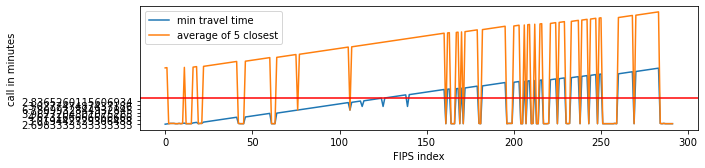

In [114]:
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(5)
ax1 = fig.add_subplot(211)
ax1.plot(census_travel_times[:,1]) #graph sanity check
ax1.plot(census_travel_times[:,2]) #graph sanity check
plt.axhline(y = 100, color = 'r', linestyle = '-')
ax1.yaxis.set_ticks(np.arange(0, 100, 15))
ax1.set_xlabel('FIPS index')
ax1.set_ylabel('call in minutes')
ax1.legend(["min travel time", "average of 5 closest"])

In [123]:
dataframe = pd.DataFrame(census_travel_times_filtered) 
dataframe

,0,1,2
0,48453000402,2.6983333333333333,5.754133333333332
1,48453001912,9.081110328638497,15.119844131455398
2,48209010805,6.151666666666667,14.163366666666667
3,48491020508,3.3525,11.898585714285714
4,48491020409,4.684192810457516,11.53617843137255
...,...,...,...
216,48453002424,3.763384353741497,8.755855102040815
217,48453001742,5.115897163120568,13.344717730496452
218,48453001760,10.6165,17.780281278538816
219,48453001826,6.07313698630137,9.99497305936073


In [125]:
dataframe.to_csv(r"geoid_min_avg_times_2018_v4.csv")

In [126]:
df = pd.read_csv("geoid_min_avg_times_2018_v4.csv")

In [127]:
df

,Unnamed: 0,0,1,2
0,0,48453000402,2.698333,5.754133
1,1,48453001912,9.081110,15.119844
2,2,48209010805,6.151667,14.163367
3,3,48491020508,3.352500,11.898586
4,4,48491020409,4.684193,11.536178
...,...,...,...,...
216,216,48453002424,3.763384,8.755855
217,217,48453001742,5.115897,13.344718
218,218,48453001760,10.616500,17.780281
219,219,48453001826,6.073137,9.994973
